In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [7]:
# 데이터 전처리
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# 새 섹션

In [8]:
# ResNet 모델 정의
resnet = torchvision.models.resnet18(pretrained=True)
resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 10)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

resnet.to(device)

# 손실 함수 및 최적화 함수
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=0.01)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
# 모델 학습
num_epochs = 10

for epoch in range(num_epochs):
    running_loss = 0.0
    resnet.train()

    for i,(inputs , labels) in enumerate(trainloader):
        inputs , labels  	= inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs=resnet(inputs)
        loss=criterion(outputs , labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()


    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}")

print("학습 완료")

Epoch 1, Loss: 0.19028155097632662
Epoch 2, Loss: 0.059149309154798484
Epoch 3, Loss: 0.0378871792329794
Epoch 4, Loss: 0.02642560245719667
Epoch 5, Loss: 0.021400732473397792
Epoch 6, Loss: 0.01392618512906291
Epoch 7, Loss: 0.011963371594390173
Epoch 8, Loss: 0.009315941702969286
Epoch 9, Loss: 0.007879342700173306
Epoch 10, Loss: 0.006669341335874245
학습 완료


In [10]:
correct=0
total=0
resnet.eval()
with torch.no_grad():
    for data in testloader:
        images ,labels=data
        images ,labels = images.to(device), labels.to(device)
        outputs=resnet(images)
        _,predicted=torch.max(outputs.data ,1 )
        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()

print(f"테스트 데이터셋 정확도: {100 * correct / total}%")

테스트 데이터셋 정확도: 98.95%


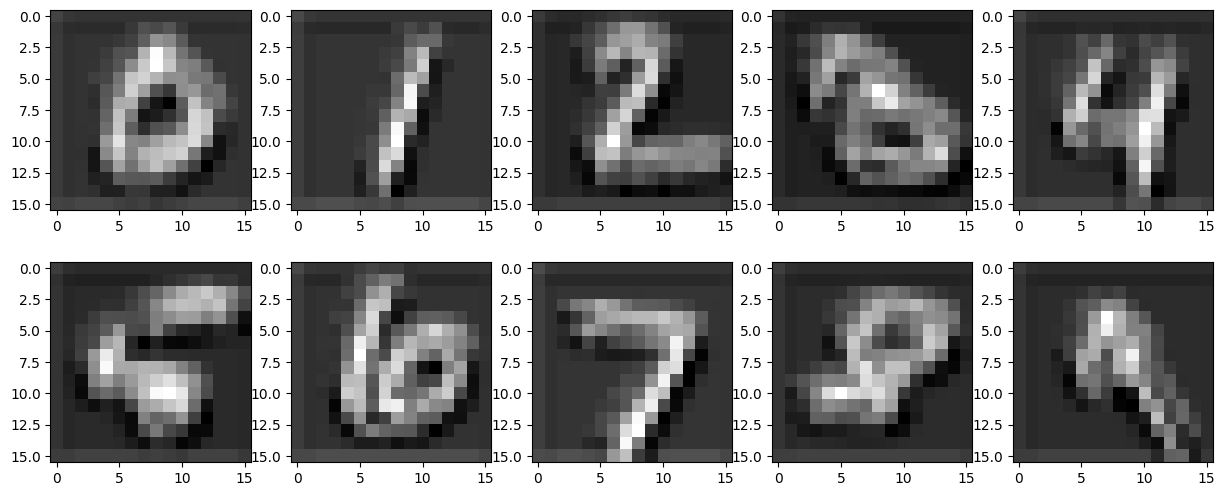

In [ ]:
import matplotlib.pyplot as plt

# 이미지 및 해당 레이블 저장
images_per_class = [None]*10
labels_per_class = [None]*10

# 테스트 데이터셋에서 각 클래스별로 한 개씩 이미지 찾기
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        for i in range(len(labels)):
            label = labels[i]
            if images_per_class[label] is None:
                images_per_class[label] = images[i]
                labels_per_class[label] = label

        if all(image is not None for image in images_per_class):
            break

feature_maps = []
for image in images_per_class:
    image_unsqueezed = image.unsqueeze(0)
    feature_map = resnet.conv1(image_unsqueezed)
    feature_maps.append(feature_map)

# 특징맵 시각화하기
fig, axs = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in enumerate(axs.flat):
    # torch.Tensor를 numpy array로 변환하기 위해 cpu로 이동하고 detach() 호출
    feature_map_cpu_np=feature_maps[i].cpu().detach().numpy()

    ax.imshow(feature_map_cpu_np[0][0], cmap='gray')

plt.show()


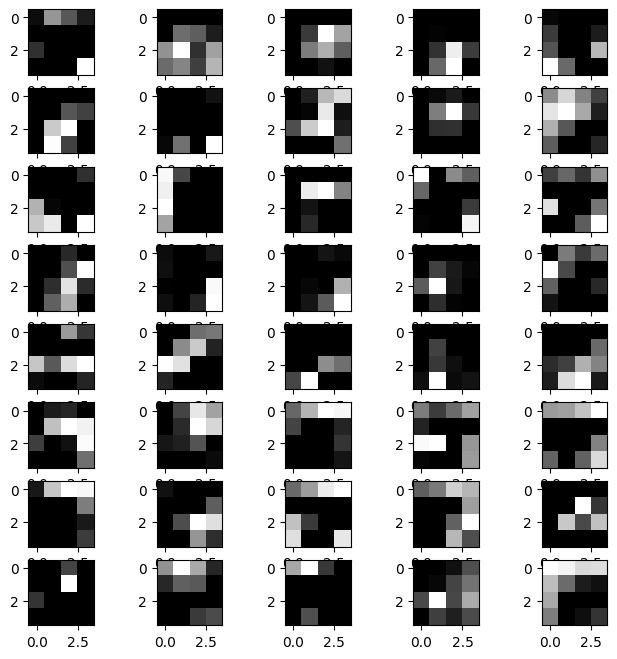

In [ ]:
# 모든 forward hook 제거
def remove_hooks(model):
    for module in model.modules():
        if hasattr(module, '_forward_hooks'):
            module._forward_hooks.clear()

# 첫 번째 이미지 선택
dataiter = iter(testloader)
images,_ = next(dataiter)
image = images[0]

# 이미지를 디바이스로 이동
if torch.cuda.is_available():
    image = image.to(device)

x = image.unsqueeze(0)  # Add batch dimension

for name, layer in resnet.named_children():
    x = layer(x)
    if name == 'layer2':
        break

feature_maps = x.detach().cpu().numpy()

from matplotlib import pyplot as plt

fig=plt.figure(figsize=(8, 8))
columns = 5
rows = 8

for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(feature_maps[0][i-1], cmap='gray')
plt.show()


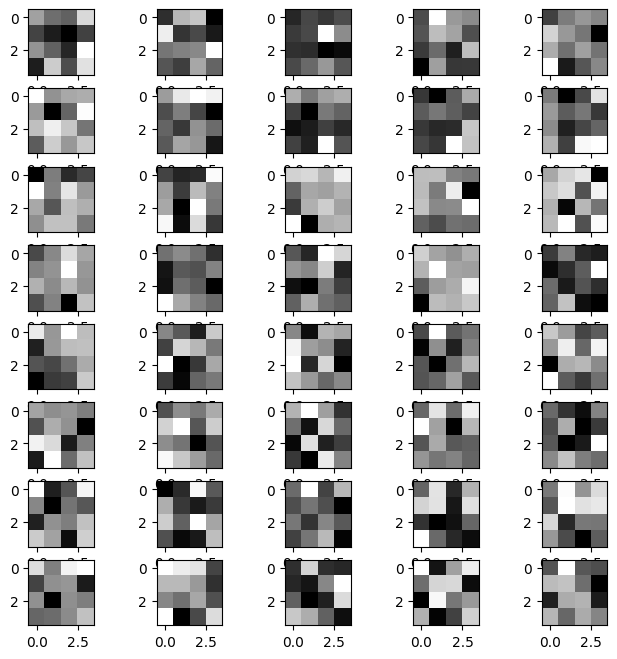

In [ ]:
import cv2
import numpy as np

feature_maps = x.detach().cpu().numpy()

fig=plt.figure(figsize=(8 , 8))
columns = 5
rows = 8

# Affine transformation matrix for moving the image more to the right.
M = np.float32([[1, 0, 10], [0, 1, 0]])

for i in range(1, columns*rows +1):
    img = feature_maps[0][i-1]

    # Apply affine transformation.
    img_moved = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))

    # Add Gaussian noise to the image.
    mean = 0
    var = 10
    sigma = var**0.5
    gaussian_noise = np.random.normal(mean, sigma, (img.shape[1], img.shape[0]))

    noisy_img_moved= img_moved + gaussian_noise

     # Create a "ghost" effect by combining the original and moved images.
    ghost_img_noisy= cv2.addWeighted(img.astype(np.float32), 0.5,noisy_img_moved.astype(np.float32), 0.5,0)
    fig.add_subplot(rows, columns,i)
    plt.imshow(ghost_img_noisy , cmap='gray')
plt.show()

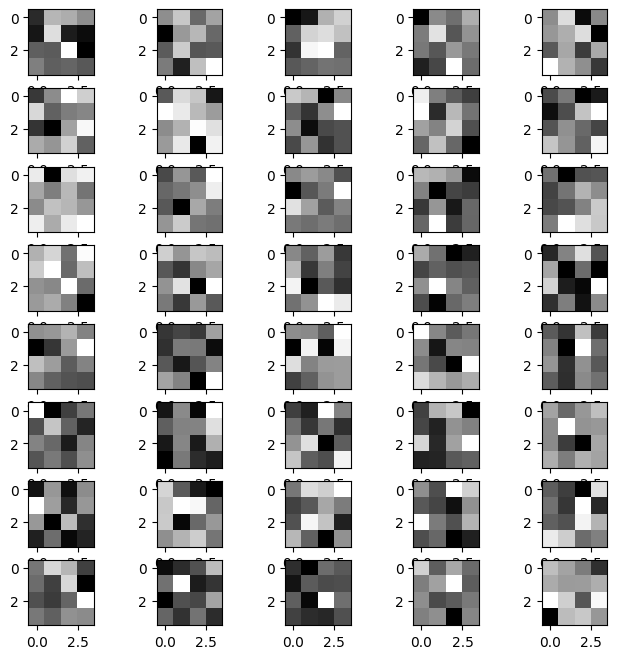

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# 첫 번째 이미지 선택
dataiter = iter(testloader)
images,_ = next(dataiter)
image = images[0]

# 이미지를 디바이스로 이동
if torch.cuda.is_available():
    image = image.to(device)

x = image.unsqueeze(0)  # Add batch dimension

for name, layer in resnet.named_children():
    x = layer(x)
    if name == 'layer2':
        break

feature_maps = x.detach().cpu().numpy()

fig=plt.figure(figsize=(8 , 8))
columns = 5
rows = 8

# Affine transformation matrix for moving the image more to the right.
M = np.float32([[1, 0, 10], [0, 1, 0]])

for i in range(1, columns*rows +1):
    img = feature_maps[0][i-1]

    # Apply affine transformation.
    img_moved = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))

    # Add Gaussian noise to the image.
    mean = 0
    var = 10
    sigma = var**0.5
    gaussian_noise=np.random.normal(mean,sigma,(img.shape[1],img.shape[0]))

    noisy_img_moved= img_moved + gaussian_noise

     # Create a "ghost" effect by combining the original and moved images.
    ghost_img_noisy= cv2.addWeighted(img.astype(np.float32),0.5,noisy_img_moved.astype(np.float32), 0.5,0)

    fig.add_subplot(rows, columns,i)
    plt.imshow(ghost_img_noisy , cmap='gray')
plt.show()

<ipython-input-25-803811a9532b>:50: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter=ax.scatter(components[idxs,0],components[idxs,1],cmap='tab10',label=f'Label {label}')


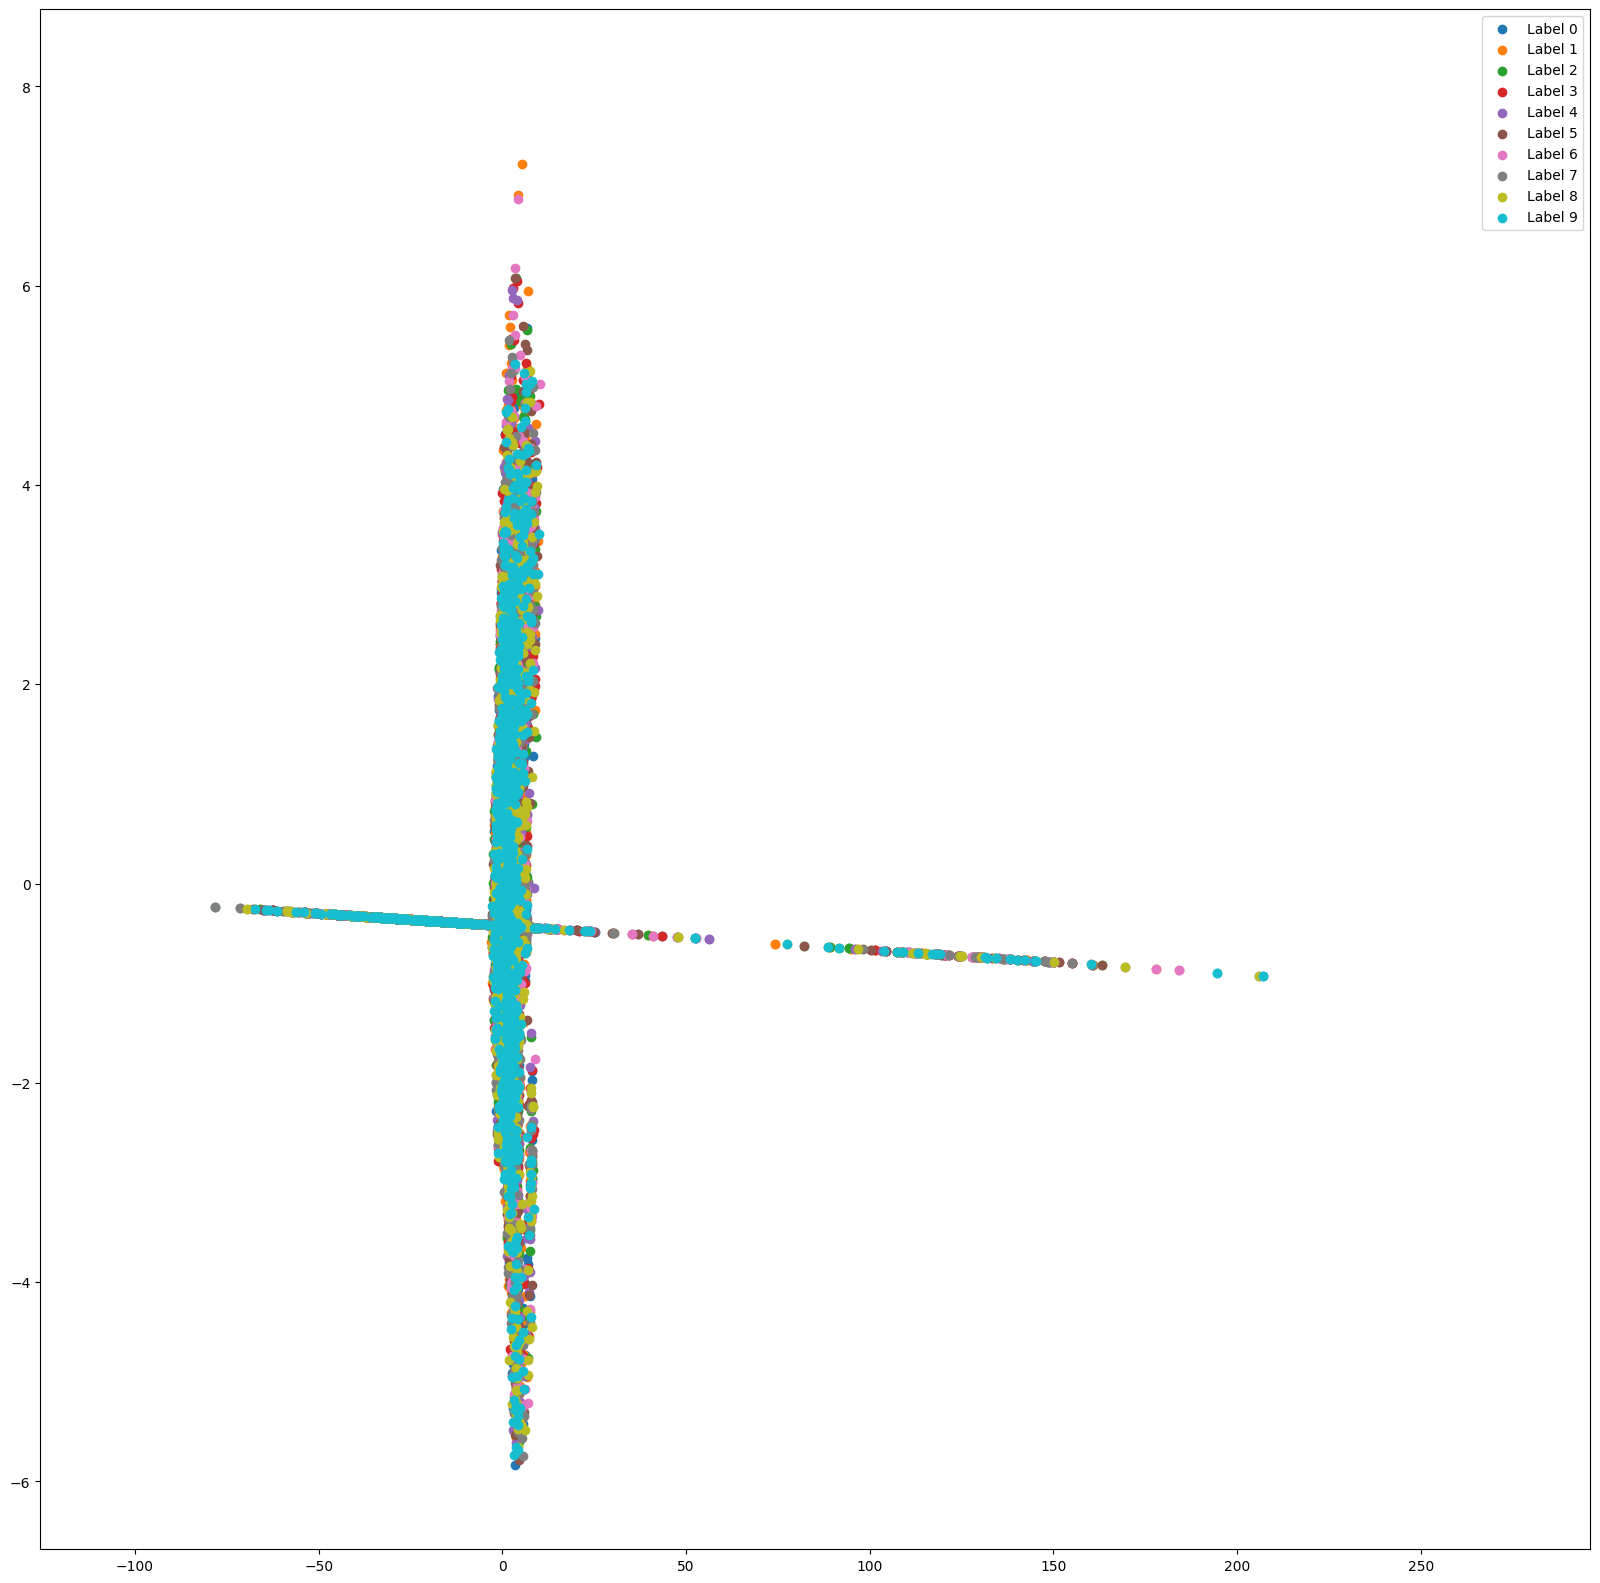

In [ ]:
import torch
import numpy as np
from sklearn.decomposition import PCA  # Import the PCA class.
import matplotlib.pyplot as plt

# Assuming testloader is already defined and contains your test images.

if torch.cuda.is_available():
    images = images.to(device)

# Define a container for feature maps.
feature_maps_list = []
labels_list = []

# Define a forward hook function to collect feature maps.
def hook_fn(module, input, output):
    feature_maps_list.append(output.squeeze().cpu().numpy())

# Register the forward hook to 'layer1' of resnet.
resnet.layer1.register_forward_hook(hook_fn)

resnet.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        if torch.cuda.is_available():
            images = images.to(device)
            labels = labels.to(device)
        for i, image in enumerate(images):
            image = image.unsqueeze(0)
            _ = resnet(image)  # Just to trigger the forward hooks.
            labels_list.append(labels[i].item())

fig, ax = plt.subplots(figsize=(20, 20))  # Increase the size of the figure.

# Flatten the feature map and convert to a NumPy array.
fm_flattened = np.array([np.resize(channel, (100,)) for fm in feature_maps_list for channel in fm])

# Check if the flattened feature map has more than one dimension.
if fm_flattened.shape[1] > 1:
   # Apply PCA to reduce dimensionality to 2D.
    pca=PCA(n_components=2)
    components=pca.fit_transform(fm_flattened)

unique_labels=np.unique(labels_list)
for label in unique_labels:
    idxs=np.where(np.array(labels_list)==label)[0]

   # Plot each channel at its PCA coordinates with color indicating cluster membership.
    scatter=ax.scatter(components[idxs,0],components[idxs,1],cmap='tab10',label=f'Label {label}')

ax.update_datalim(components)
ax.autoscale()
plt.legend()  # Add a legend
plt.show()

<ipython-input-8-5947ea25daed>:50: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter=ax.scatter(components[idxs,0],components[idxs,1],cmap='tab10',label=f'Label {label}')


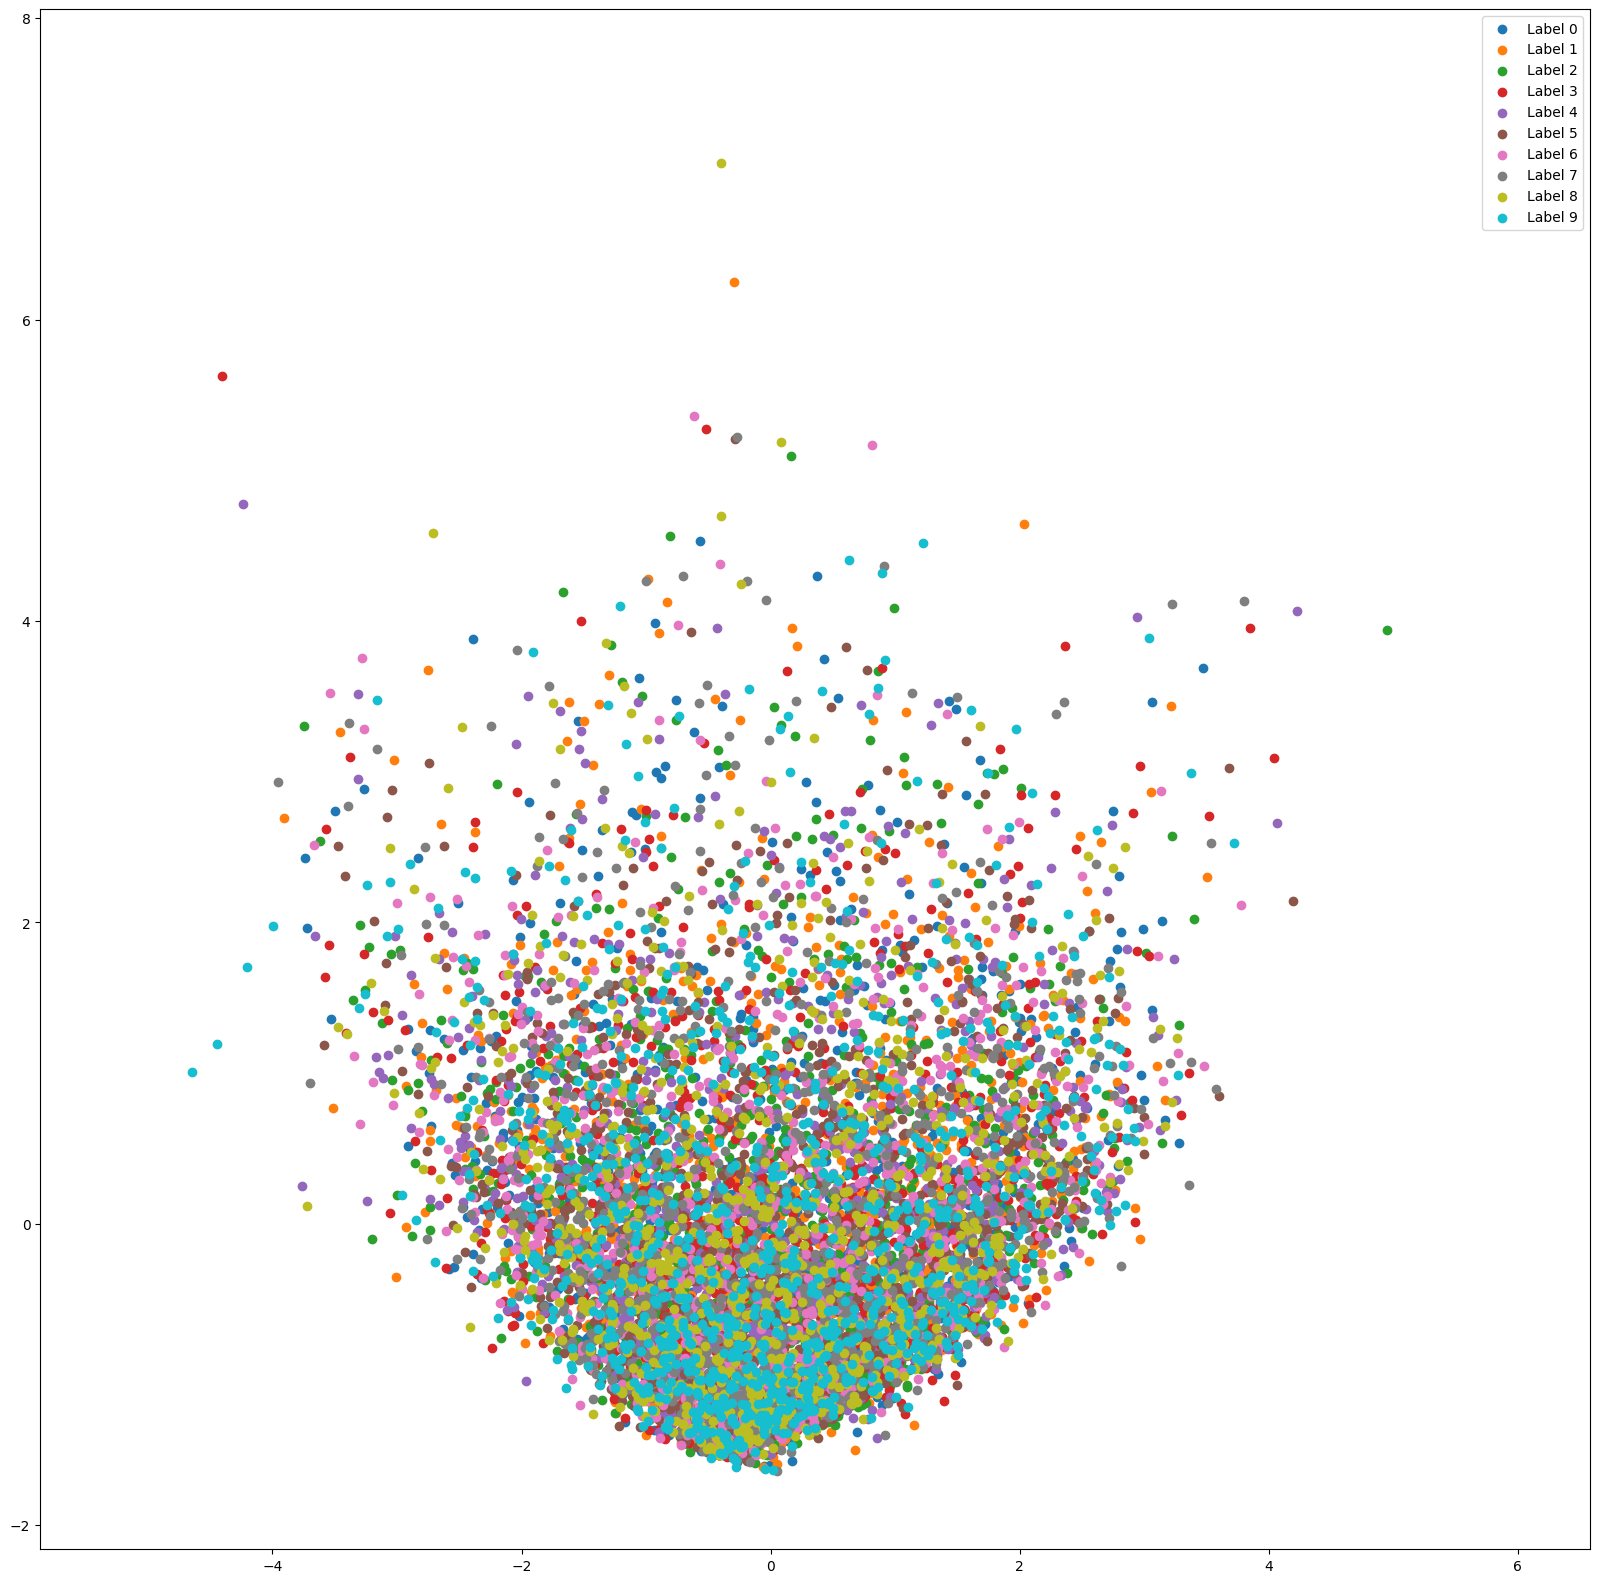

In [8]:
import torch
import numpy as np
from sklearn.decomposition import PCA  # Import the PCA class.
import matplotlib.pyplot as plt

# Assuming testloader is already defined and contains your test images.

if torch.cuda.is_available():
    images = images.to(device)

# Define a container for feature maps.
feature_maps_list = []
labels_list = []

# Define a forward hook function to collect feature maps.
def hook_fn(module, input, output):
    feature_maps_list.append(output.squeeze().cpu().numpy())

# Register the forward hook to 'layer2' of resnet.
resnet.layer2.register_forward_hook(hook_fn)

resnet.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        if torch.cuda.is_available():
            images = images.to(device)
            labels = labels.to(device)
        for i, image in enumerate(images):
            image = image.unsqueeze(0)
            _ = resnet(image)  # Just to trigger the forward hooks.
            labels_list.append(labels[i].item())

fig, ax = plt.subplots(figsize=(20, 20))  # Increase the size of the figure.

# Flatten the feature map and convert to a NumPy array.
fm_flattened = np.array([np.resize(channel, (100,)) for fm in feature_maps_list for channel in fm])

# Check if the flattened feature map has more than one dimension.
if fm_flattened.shape[1] > 1:
   # Apply PCA to reduce dimensionality to 2D.
    pca=PCA(n_components=2)
    components=pca.fit_transform(fm_flattened)

unique_labels=np.unique(labels_list)
for label in unique_labels:
    idxs=np.where(np.array(labels_list)==label)[0]

   # Plot each channel at its PCA coordinates with color indicating cluster membership.
    scatter=ax.scatter(components[idxs,0],components[idxs,1],cmap='tab10',label=f'Label {label}')

ax.update_datalim(components)
ax.autoscale()
plt.legend()  # Add a legend
plt.show()


In [10]:
import torch
import numpy as np
import cv2
import os

# Assuming resnet and testloader are already defined and contains your test images.
# Define a container for feature maps.
feature_maps_list = []

# Define a forward hook function to collect feature maps.
def hook_fn(module, input, output):
    feature_maps_list.append(output.squeeze().cpu().numpy())

# Register the forward hook to 'layer1' of resnet.
resnet.layer1.register_forward_hook(hook_fn)

resnet.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        if torch.cuda.is_available():
            images = images.to(device)
            labels = labels.to(device)
        for i, image in enumerate(images):
            image = image.unsqueeze(0)
            _ = resnet(image)  # Just to trigger the forward hooks.

dir_name='open'
if not os.path.exists(dir_name):
    os.mkdir(dir_name)

for idx in range(len(feature_maps_list)):

   # If there are multiple channels in the feature map,
   # use only the first channel to create an image.
   if len(feature_maps_list[idx].shape) > 2:
       feature_img=feature_maps_list[idx][0,:,:]
   else:
       feature_img=feature_maps_list[idx]

   # Normalize to 0-255 scale and convert it into uint8 type
   feature_img=((feature_img-np.min(feature_img))/(np.max(feature_img)-np.min(feature_img))*255).astype(np.uint8)

   # Save original image file in the specified directory.
   file_path=os.path.join(dir_name,f'original_feature_map_{idx}.png')

   cv2.imwrite(file_path,feature_img)

   print(f"Saving original image: {file_path}")

   # Add Gaussian noise with less standard deviation 10 times and save each noisy image separately.
   mean=0
   stddev=3

   for j in range(10):

       noise=np.random.normal(mean,stddev,feature_img.shape).astype(np.uint8)

       noisy_feature_img_gray_single_channel=cv2.add(feature_img,noise)

       file_path=os.path.join(dir_name,f'noisy_feature_map_{idx}_{j}.png')

       cv2.imwrite(file_path,noisy_feature_img_gray_single_channel)

       print(f"Saving noisy image: {file_path}")

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Saving noisy image: open/noisy_feature_map_29545_4.png
Saving noisy image: open/noisy_feature_map_29545_5.png
Saving noisy image: open/noisy_feature_map_29545_6.png
Saving noisy image: open/noisy_feature_map_29545_7.png
Saving noisy image: open/noisy_feature_map_29545_8.png
Saving noisy image: open/noisy_feature_map_29545_9.png
Saving original image: open/original_feature_map_29546.png
Saving noisy image: open/noisy_feature_map_29546_0.png
Saving noisy image: open/noisy_feature_map_29546_1.png
Saving noisy image: open/noisy_feature_map_29546_2.png
Saving noisy image: open/noisy_feature_map_29546_3.png
Saving noisy image: open/noisy_feature_map_29546_4.png
Saving noisy image: open/noisy_feature_map_29546_5.png
Saving noisy image: open/noisy_feature_map_29546_6.png
Saving noisy image: open/noisy_feature_map_29546_7.png
Saving noisy image: open/noisy_feature_map_29546_8.png
Saving noisy image: open/noisy_feature_map_29546_9.png
Saving original image: op

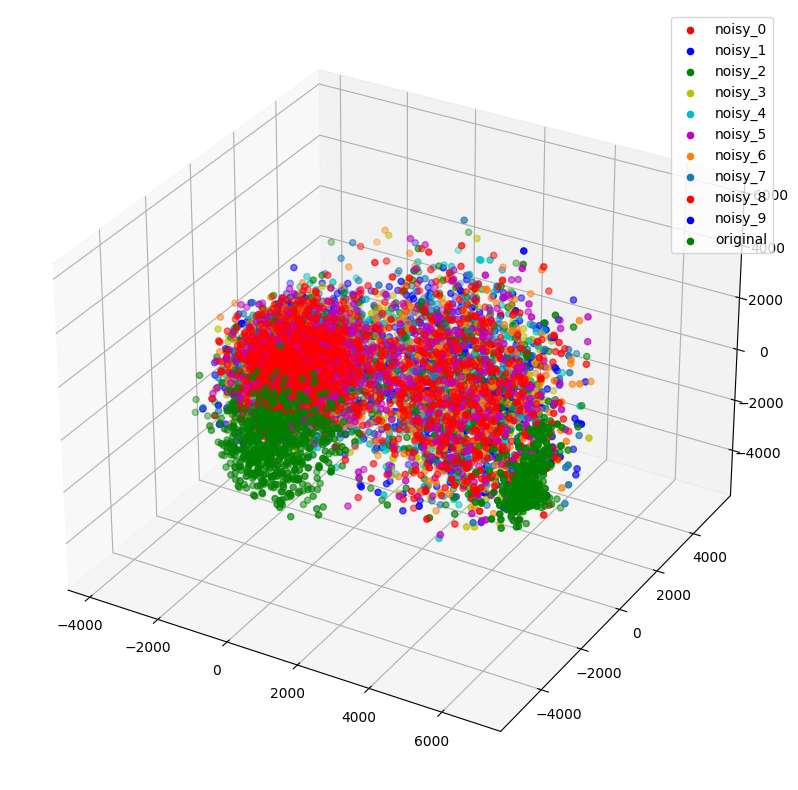

In [3]:
import os
import cv2
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Directory containing the images.
dir_name='open'

# Read all image files.
image_files=[os.path.join(dir_name,f) for f in os.listdir(dir_name) if f.endswith('.png')]

# Limit to first 10000 images.
image_files = image_files[:10000]

images_data=[]
labels=[]

for image_file in image_files:

   img_data=cv2.imread(image_file,cv2.IMREAD_GRAYSCALE)

   # Resize each image to a fixed size (for example, 64x64).
   img_data=cv2.resize(img_data,(64,64)).flatten()

   images_data.append(img_data)

   # Extract label from file name (assuming it's the part before the last underscore).
   base_filename = os.path.splitext(os.path.basename(image_file))[0]

   if 'original' in base_filename:
       label = 'original'
   else:  # 'noisy' in filename
       label='noisy_' + base_filename.split('_')[-1]

   labels.append(label)

images_array=np.array(images_data)

pca=PCA(n_components=3)
components=pca.fit_transform(images_array)

fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111, projection='3d')

unique_labels=np.unique(labels)
colors=['r', 'b', 'g', 'y', 'c', 'm', '#ff7f0e', '#1f77b4'] * 10

for i, label in enumerate(unique_labels):

     idxs=np.where(np.array(labels)==label)[0]

     ax.scatter(components[idxs,0], components[idxs,1], components[idxs,2], c=colors[i % len(colors)], label=f'{label}')

plt.legend()
plt.show()


In [ ]:
import torch
import numpy as np
import cv2
import os

# Assuming resnet and testloader are already defined and contains your test images.
# Define a container for feature maps.
feature_maps_list = []

# Define a forward hook function to collect feature maps.
def hook_fn(module, input, output):
    feature_maps_list.append(output.squeeze().cpu().numpy())

# Register the forward hook to 'layer2' of resnet.
resnet.layer2.register_forward_hook(hook_fn)

resnet.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        if torch.cuda.is_available():
            images = images.to(device)
            labels = labels.to(device)
        for i, image in enumerate(images):
            image = image.unsqueeze(0)
            _ = resnet(image)  # Just to trigger the forward hooks.

dir_name='open1'
if not os.path.exists(dir_name):
    os.mkdir(dir_name)

for idx in range(len(feature_maps_list)):

   # If there are multiple channels in the feature map,
   # use only the first channel to create an image.
   if len(feature_maps_list[idx].shape) > 2:
       feature_img=feature_maps_list[idx][0,:,:]
   else:
       feature_img=feature_maps_list[idx]

   # Normalize to 0-255 scale and convert it into uint8 type
   feature_img=((feature_img-np.min(feature_img))/(np.max(feature_img)-np.min(feature_img))*255).astype(np.uint8)

   # Save original image file in the specified directory.
   file_path=os.path.join(dir_name,f'original_feature_map_{idx}.png')

   cv2.imwrite(file_path,feature_img)

   print(f"Saving original image: {file_path}")

   # Add Gaussian noise with less standard deviation 10 times and save each noisy image separately.
   mean=0
   stddev=3

   for j in range(10):

       noise=np.random.normal(mean,stddev,feature_img.shape).astype(np.uint8)

       noisy_feature_img_gray_single_channel=cv2.add(feature_img,noise)

       file_path=os.path.join(dir_name,f'noisy_feature_map_{idx}_{j}.png')

       cv2.imwrite(file_path,noisy_feature_img_gray_single_channel)

       print(f"Saving noisy image: {file_path}")

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Saving noisy image: open1/noisy_feature_map_10_2.png
Saving noisy image: open1/noisy_feature_map_10_3.png
Saving noisy image: open1/noisy_feature_map_10_4.png
Saving noisy image: open1/noisy_feature_map_10_5.png
Saving noisy image: open1/noisy_feature_map_10_6.png
Saving noisy image: open1/noisy_feature_map_10_7.png
Saving noisy image: open1/noisy_feature_map_10_8.png
Saving noisy image: open1/noisy_feature_map_10_9.png
Saving original image: open1/original_feature_map_11.png
Saving noisy image: open1/noisy_feature_map_11_0.png
Saving noisy image: open1/noisy_feature_map_11_1.png
Saving noisy image: open1/noisy_feature_map_11_2.png
Saving noisy image: open1/noisy_feature_map_11_3.png
Saving noisy image: open1/noisy_feature_map_11_4.png
Saving noisy image: open1/noisy_feature_map_11_5.png
Saving noisy image: open1/noisy_feature_map_11_6.png
Saving noisy image: open1/noisy_feature_map_11_7.png
Saving noisy image: open1/noisy_feature_map_11_8.png
Saving

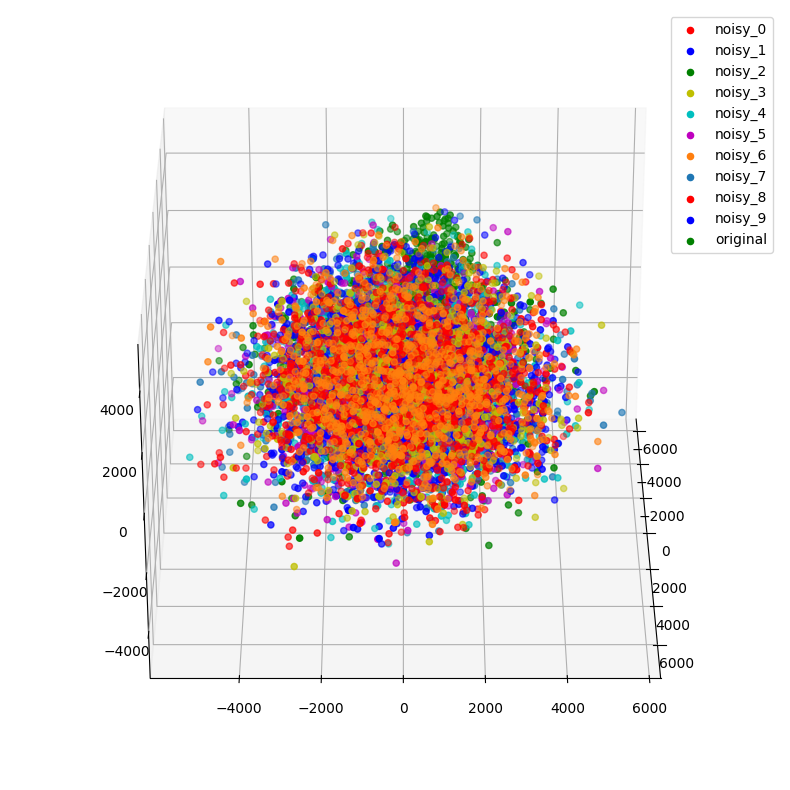

In [13]:
import os
import cv2
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import imageio

# Directory containing the images.
dir_name='open1'

# Read all image files.
image_files=[os.path.join(dir_name,f) for f in os.listdir(dir_name) if f.endswith('.png')]

# Limit to first 10000 images.
image_files = image_files[:10000]

images_data=[]
labels=[]

for image_file in image_files:

   img_data=cv2.imread(image_file,cv2.IMREAD_GRAYSCALE)

   # Resize each image to a fixed size (for example, 64x64).
   img_data=cv2.resize(img_data,(64,64)).flatten()

   images_data.append(img_data)

   # Extract label from file name (assuming it's the part before the last underscore).
   base_filename = os.path.splitext(os.path.basename(image_file))[0]

   if 'original' in base_filename:
       label = 'original'
   else:  # 'noisy' in filename
       label='noisy_' + base_filename.split('_')[-1]

   labels.append(label)

images_array=np.array(images_data)

pca=PCA(n_components=3)
components=pca.fit_transform(images_array)

fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111, projection='3d')

unique_labels=np.unique(labels)
colors=['r', 'b', 'g', 'y', 'c', 'm', '#ff7f0e', '#1f77b4'] * 10

for i, label in enumerate(unique_labels):

     idxs=np.where(np.array(labels)==label)[0]

     ax.scatter(components[idxs,0], components[idxs,1], components[idxs,2], c=colors[i % len(colors)], label=f'{label}')

plt.legend()

def update(num):
    ax.view_init(elev=30., azim=num)

ani = FuncAnimation(fig, update, frames=np.arange(0,360), interval=100)

ani.save('rotating_plot.gif', writer='imagemagick')

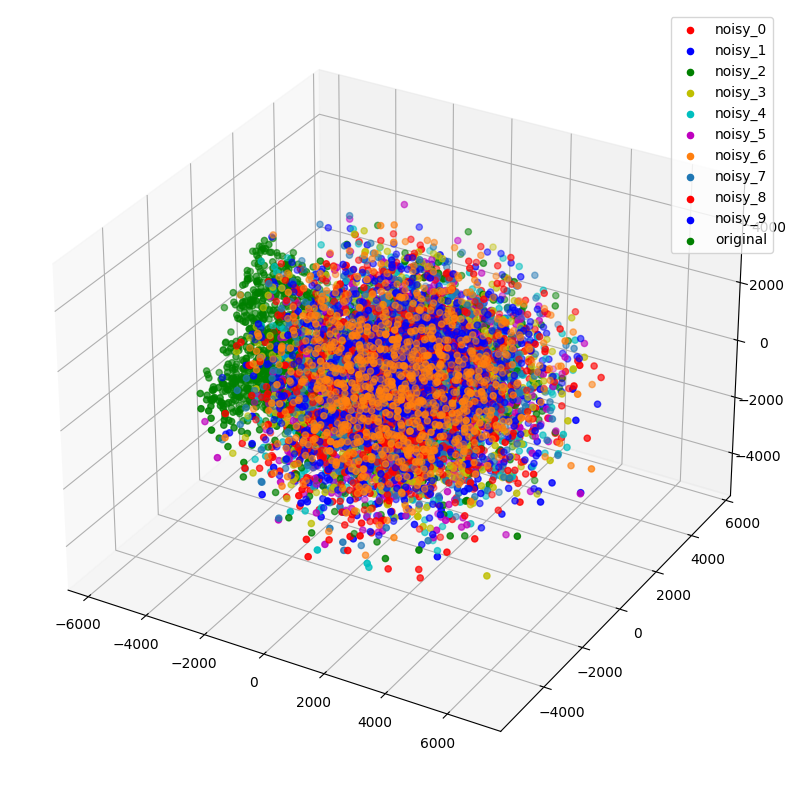

In [14]:
import os
import cv2
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Directory containing the images.
dir_name='open1'

# Read all image files.
image_files=[os.path.join(dir_name,f) for f in os.listdir(dir_name) if f.endswith('.png')]

# Limit to first 10000 images.
image_files = image_files[:10000]

images_data=[]
labels=[]

for image_file in image_files:

   img_data=cv2.imread(image_file,cv2.IMREAD_GRAYSCALE)

   # Resize each image to a fixed size (for example, 64x64).
   img_data=cv2.resize(img_data,(64,64)).flatten()

   images_data.append(img_data)

   # Extract label from file name (assuming it's the part before the last underscore).
   base_filename = os.path.splitext(os.path.basename(image_file))[0]

   if 'original' in base_filename:
       label = 'original'
   else:  # 'noisy' in filename
       label='noisy_' + base_filename.split('_')[-1]

   labels.append(label)

images_array=np.array(images_data)

pca=PCA(n_components=3)
components=pca.fit_transform(images_array)

fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111, projection='3d')

unique_labels=np.unique(labels)
colors=['r', 'b', 'g', 'y', 'c', 'm', '#ff7f0e', '#1f77b4'] * 10

for i, label in enumerate(unique_labels):

     idxs=np.where(np.array(labels)==label)[0]

     ax.scatter(components[idxs,0], components[idxs,1], components[idxs,2], c=colors[i % len(colors)], label=f'{label}')

plt.legend()
plt.show()


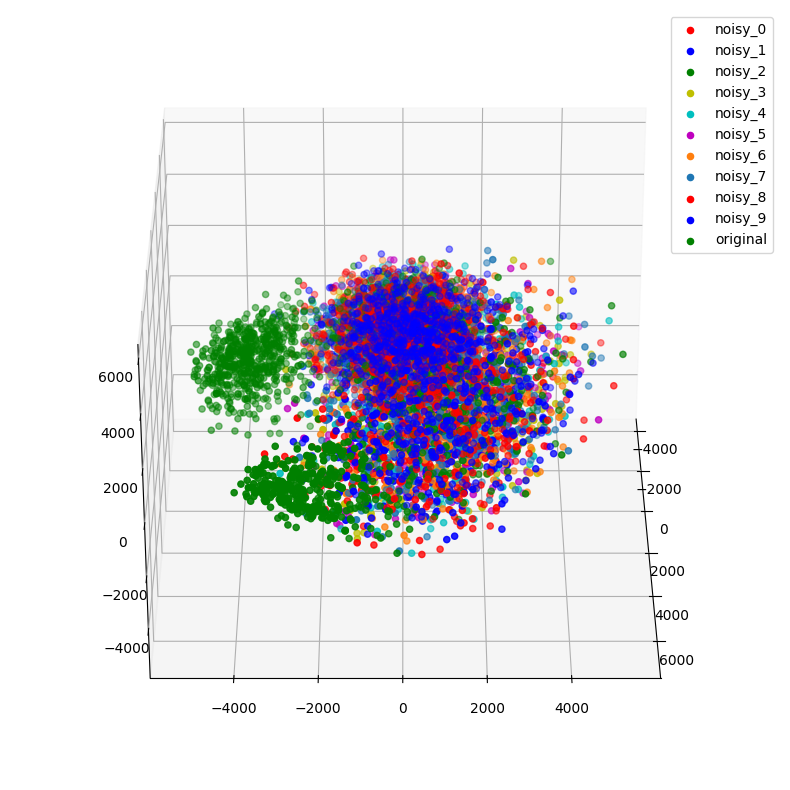

In [15]:
import os
import cv2
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import imageio

# Directory containing the images.
dir_name='open'

# Read all image files.
image_files=[os.path.join(dir_name,f) for f in os.listdir(dir_name) if f.endswith('.png')]

# Limit to first 10000 images.
image_files = image_files[:10000]

images_data=[]
labels=[]

for image_file in image_files:

   img_data=cv2.imread(image_file,cv2.IMREAD_GRAYSCALE)

   # Resize each image to a fixed size (for example, 64x64).
   img_data=cv2.resize(img_data,(64,64)).flatten()

   images_data.append(img_data)

   # Extract label from file name (assuming it's the part before the last underscore).
   base_filename = os.path.splitext(os.path.basename(image_file))[0]

   if 'original' in base_filename:
       label = 'original'
   else:  # 'noisy' in filename
       label='noisy_' + base_filename.split('_')[-1]

   labels.append(label)

images_array=np.array(images_data)

pca=PCA(n_components=3)
components=pca.fit_transform(images_array)

fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111, projection='3d')

unique_labels=np.unique(labels)
colors=['r', 'b', 'g', 'y', 'c', 'm', '#ff7f0e', '#1f77b4'] * 10

for i, label in enumerate(unique_labels):

     idxs=np.where(np.array(labels)==label)[0]

     ax.scatter(components[idxs,0], components[idxs,1], components[idxs,2], c=colors[i % len(colors)], label=f'{label}')

plt.legend()

def update(num):
    ax.view_init(elev=30., azim=num)

ani = FuncAnimation(fig, update, frames=np.arange(0,360), interval=100)

ani.save('rotating_plot.gif', writer='imagemagick')